In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gensim --quiet
!pip install imbalanced-learn --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 40.8 MB/s eta 0:00:00


In [17]:
import pandas as Cus_tkt_pd
import numpy as Cus_tkt_np
import matplotlib.pyplot as Cus_tkt_plt
import seaborn as Cus_tkt_sns
from gensim.models import Word2Vec as Cus_tkt_Word2Vec
from tqdm import tqdm as Cus_tkt_tqdm
from sklearn.preprocessing import LabelEncoder as Cus_tkt_LabelEncoder
from sklearn.preprocessing import MinMaxScaler as Cus_tkt_MinMaxScaler
from sklearn.preprocessing import Binarizer as Cus_tkt_Binarizer
from sklearn.model_selection import train_test_split as Cus_tkt_train_test_split
from sklearn.model_selection import GridSearchCV as Cus_tkt_GridSearchCV
from sklearn.metrics import (
    classification_report as Cus_tkt_classification_report,
    confusion_matrix as Cus_tkt_confusion_matrix,
    ConfusionMatrixDisplay as Cus_tkt_ConfusionMatrixDisplay,
    roc_auc_score as Cus_tkt_roc_auc_score,
    roc_curve as Cus_tkt_roc_curve,
)
from sklearn.naive_bayes import MultinomialNB as Cus_tkt_MultinomialNB
from sklearn.naive_bayes import BernoulliNB as Cus_tkt_BernoulliNB
from sklearn.svm import LinearSVC as Cus_tkt_LinearSVC
from sklearn.calibration import CalibratedClassifierCV as Cus_tkt_CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold as Cus_tkt_StratifiedKFold
from imblearn.over_sampling import SMOTE as Cus_tkt_SMOTE
import os as Cus_tkt_os
import joblib as Cus_tkt_joblib
from sklearn.model_selection import ParameterGrid as Cus_tkt_ParameterGrid

In [4]:
# Load preprocessed CSV
Cus_tkt_input_path = "/content/drive/My Drive/Code/Cus_tkt_preprocessed_dataset.csv"

Cus_tkt_df = Cus_tkt_pd.read_csv(Cus_tkt_input_path)

print("Loaded dataframe shape:", Cus_tkt_df.shape)
print("Columns:", Cus_tkt_df.columns.tolist())

# show class distribution
print("\nClass distribution:")
print(Cus_tkt_df["Cus_tkt_target"].value_counts())


Loaded dataframe shape: (61765, 21)
Columns: ['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language', 'version', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'Cus_tkt_clean_subject', 'Cus_tkt_clean_body', 'Cus_tkt_merged_text', 'Cus_tkt_target', 'Cus_tkt_text_length']

Class distribution:
Cus_tkt_target
Incident    19444
Request     13950
Problem     10196
Change       4997
Name: count, dtype: int64


In [5]:
# Prepare tokens and train Word2Vec

Cus_tkt_df["Cus_tkt_tokens"] = Cus_tkt_df["Cus_tkt_merged_text"].fillna("").astype(str).apply(lambda Cus_tkt_x: Cus_tkt_x.split())

# quick sanity
print("Example tokens:", Cus_tkt_df["Cus_tkt_tokens"].iloc[0][:20])

# Word2Vec config
Cus_tkt_W2V_VECTOR_SIZE = 200
Cus_tkt_W2V_WINDOW = 5
Cus_tkt_W2V_MIN_COUNT = 2
Cus_tkt_W2V_WORKERS = 4
Cus_tkt_W2V_SG = 1  # skip-gram

Cus_tkt_sentences = Cus_tkt_df["Cus_tkt_tokens"].tolist()

Cus_tkt_w2v_model = Cus_tkt_Word2Vec(
    sentences=Cus_tkt_sentences,
    vector_size=Cus_tkt_W2V_VECTOR_SIZE,
    window=Cus_tkt_W2V_WINDOW,
    min_count=Cus_tkt_W2V_MIN_COUNT,
    workers=Cus_tkt_W2V_WORKERS,
    sg=Cus_tkt_W2V_SG,
    seed=42
)

print("Trained Word2Vec — vocab size:", len(Cus_tkt_w2v_model.wv.index_to_key))


Example tokens: ['wesentlicher', 'sicherheitsvorfall', 'sehr', 'geehrtes', 'supportteamnnich', 'möchte', 'einen', 'gravierenden', 'sicherheitsvorfall', 'melden', 'der', 'gegenwärtig', 'mehrere', 'komponenten', 'unserer', 'infrastruktur', 'betrifft', 'betroffene', 'geräte', 'umfassen']
Trained Word2Vec — vocab size: 31672


In [6]:
# Create averaged document vectors (Word2Vec -> document)

def Cus_tkt_document_vector(Cus_tkt_tokens, Cus_tkt_model, Cus_tkt_vector_size):
    if not Cus_tkt_tokens:
        return Cus_tkt_np.zeros(Cus_tkt_vector_size, dtype=float)
    Cus_tkt_vecs = [Cus_tkt_model.wv[Cus_tkt_w] for Cus_tkt_w in Cus_tkt_tokens if Cus_tkt_w in Cus_tkt_model.wv]
    if len(Cus_tkt_vecs) == 0:
        return Cus_tkt_np.zeros(Cus_tkt_vector_size, dtype=float)
    return Cus_tkt_np.mean(Cus_tkt_vecs, axis=0)

Cus_tkt_df["Cus_tkt_w2v_vector"] = Cus_tkt_df["Cus_tkt_tokens"].apply(
    lambda Cus_tkt_toks: Cus_tkt_document_vector(Cus_tkt_toks, Cus_tkt_w2v_model, Cus_tkt_W2V_VECTOR_SIZE)
)

# Stack into X matrix
Cus_tkt_X = Cus_tkt_np.vstack(Cus_tkt_df["Cus_tkt_w2v_vector"].to_numpy())
Cus_tkt_y_raw = Cus_tkt_df["Cus_tkt_target"].astype(str).values

print("Cus_tkt_X shape:", Cus_tkt_X.shape)

Cus_tkt_X shape: (61765, 200)


In [7]:
# Encode labels and split
Cus_tkt_label_encoder = Cus_tkt_LabelEncoder()
Cus_tkt_y = Cus_tkt_label_encoder.fit_transform(Cus_tkt_y_raw)

# Get class names
Cus_tkt_classes = list(Cus_tkt_label_encoder.classes_)

# Train-test split (stratify)
Cus_tkt_X_train, Cus_tkt_X_test, Cus_tkt_y_train, Cus_tkt_y_test = Cus_tkt_train_test_split(
    Cus_tkt_X, Cus_tkt_y, test_size=0.20, random_state=42, stratify=Cus_tkt_y
)

print("Train shape:", Cus_tkt_X_train.shape, "Test shape:", Cus_tkt_X_test.shape)

# Apply SMOTE on training set
Cus_tkt_smote = Cus_tkt_SMOTE(random_state=42)
Cus_tkt_X_train_res, Cus_tkt_y_train_res = Cus_tkt_smote.fit_resample(
    Cus_tkt_X_train, Cus_tkt_y_train
)

print("After SMOTE — Train shape:", Cus_tkt_X_train_res.shape)

# Optional: inspect new class counts
import collections as Cus_tkt_collections
print("Resampled class distribution:", Cus_tkt_collections.Counter(Cus_tkt_y_train_res))

Train shape: (49412, 200) Test shape: (12353, 200)
After SMOTE — Train shape: (77775, 200)
Resampled class distribution: Counter({np.int64(1): 15555, np.int64(0): 15555, np.int64(2): 15555, np.int64(4): 15555, np.int64(3): 15555})



================ SVM ================
Training SVM...
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



SVM Classification Report:
              precision    recall  f1-score   support

      Change       0.85      0.93      0.89       999
    Incident       0.75      0.62      0.68      3889
     Problem       0.46      0.60      0.52      2039
     Request       0.98      0.96      0.97      2790
         nan       1.00      1.00      1.00      2636

    accuracy                           0.80     12353
   macro avg       0.81      0.82      0.81     12353
weighted avg       0.82      0.80      0.80     12353



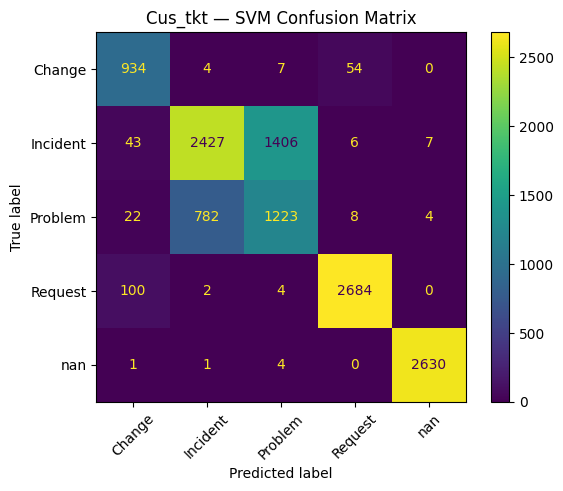

SVM ROC-AUC: 0.9558592806852003


In [19]:
# MODEL 1 — Linear SVM

print("\n================ SVM ================")

Cus_tkt_svm_model = Cus_tkt_LinearSVC(random_state=42)

Cus_tkt_svm_param_grid = {
    "C": [0.1, 1, 5]
}

Cus_tkt_svm_grid = Cus_tkt_GridSearchCV(
    estimator=Cus_tkt_svm_model,
    param_grid=Cus_tkt_svm_param_grid,
    scoring="f1_macro",
    cv=2,
    n_jobs=-1,
    verbose=1
)

print("Training SVM...")
Cus_tkt_svm_grid.fit(Cus_tkt_X_train_res, Cus_tkt_y_train_res)
Cus_tkt_svm_best = Cus_tkt_svm_grid.best_estimator_

# Calibrate for probabilities (required for ROC)
Cus_tkt_svm_calibrated = Cus_tkt_CalibratedClassifierCV(Cus_tkt_svm_best, cv="prefit")
Cus_tkt_svm_calibrated.fit(Cus_tkt_X_train_res, Cus_tkt_y_train_res)

Cus_tkt_y_pred_svm = Cus_tkt_svm_calibrated.predict(Cus_tkt_X_test)

print("\nSVM Classification Report:")
print(Cus_tkt_classification_report(Cus_tkt_y_test, Cus_tkt_y_pred_svm, target_names=Cus_tkt_classes))

Cus_tkt_ConfusionMatrixDisplay.from_predictions(
    Cus_tkt_y_test, Cus_tkt_y_pred_svm, display_labels=Cus_tkt_classes, xticks_rotation=45
)
Cus_tkt_plt.title("Cus_tkt — SVM Confusion Matrix")
Cus_tkt_plt.show()

Cus_tkt_y_proba_svm = Cus_tkt_svm_calibrated.predict_proba(Cus_tkt_X_test)
print("SVM ROC-AUC:", Cus_tkt_roc_auc_score(Cus_tkt_y_test, Cus_tkt_y_proba_svm, multi_class="ovr"))



================ MultinomialNB ================
Training MultinomialNB...
Fitting 2 folds for each of 3 candidates, totalling 6 fits

MultinomialNB Classification Report:
              precision    recall  f1-score   support

      Change       0.66      0.60      0.63       999
    Incident       0.69      0.58      0.63      3889
     Problem       0.50      0.20      0.29      2039
     Request       0.97      0.61      0.75      2790
         nan       0.47      1.00      0.64      2636

    accuracy                           0.61     12353
   macro avg       0.66      0.60      0.59     12353
weighted avg       0.67      0.61      0.60     12353



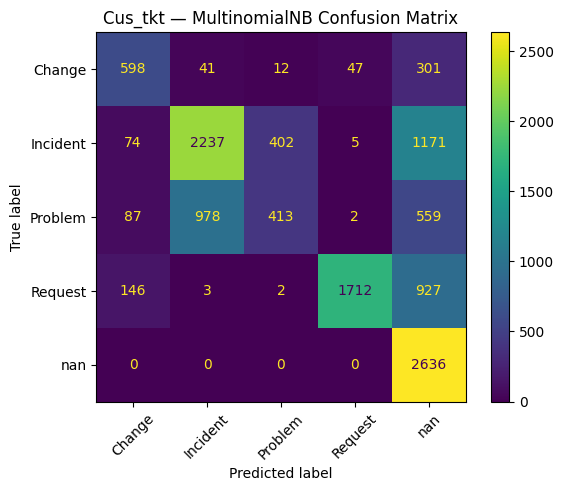

MNB ROC-AUC: 0.8164073712464545


In [20]:
# MODEL 2 — MultinomialNB

print("\n================ MultinomialNB ================")

# Scaling required for non-negative inputs
Cus_tkt_scaler_mnb = Cus_tkt_MinMaxScaler()
Cus_tkt_X_train_mnb = Cus_tkt_scaler_mnb.fit_transform(Cus_tkt_X_train_res)
Cus_tkt_X_test_mnb  = Cus_tkt_scaler_mnb.transform(Cus_tkt_X_test)

Cus_tkt_mnb_model = Cus_tkt_MultinomialNB()

Cus_tkt_mnb_param_grid = {
    "alpha": [0.1, 0.5, 1.0]
}

Cus_tkt_mnb_grid = Cus_tkt_GridSearchCV(
    estimator=Cus_tkt_mnb_model,
    param_grid=Cus_tkt_mnb_param_grid,
    scoring="f1_macro",
    cv=2,
    n_jobs=-1,
    verbose=1
)

print("Training MultinomialNB...")
Cus_tkt_mnb_grid.fit(Cus_tkt_X_train_mnb, Cus_tkt_y_train_res)
Cus_tkt_mnb_best = Cus_tkt_mnb_grid.best_estimator_

Cus_tkt_y_pred_mnb = Cus_tkt_mnb_best.predict(Cus_tkt_X_test_mnb)

print("\nMultinomialNB Classification Report:")
print(Cus_tkt_classification_report(Cus_tkt_y_test, Cus_tkt_y_pred_mnb, target_names=Cus_tkt_classes))

Cus_tkt_ConfusionMatrixDisplay.from_predictions(
    Cus_tkt_y_test, Cus_tkt_y_pred_mnb, display_labels=Cus_tkt_classes, xticks_rotation=45
)
Cus_tkt_plt.title("Cus_tkt — MultinomialNB Confusion Matrix")
Cus_tkt_plt.show()

Cus_tkt_y_proba_mnb = Cus_tkt_mnb_best.predict_proba(Cus_tkt_X_test_mnb)
print("MNB ROC-AUC:", Cus_tkt_roc_auc_score(Cus_tkt_y_test, Cus_tkt_y_proba_mnb, multi_class="ovr"))


================ BernoulliNB ================
Training BernoulliNB...
Fitting 2 folds for each of 3 candidates, totalling 6 fits

BernoulliNB Classification Report:
              precision    recall  f1-score   support

      Change       0.58      0.54      0.56       999
    Incident       0.68      0.56      0.61      3889
     Problem       0.45      0.27      0.34      2039
     Request       0.92      0.77      0.84      2790
         nan       0.57      1.00      0.72      2636

    accuracy                           0.65     12353
   macro avg       0.64      0.63      0.61     12353
weighted avg       0.66      0.65      0.64     12353



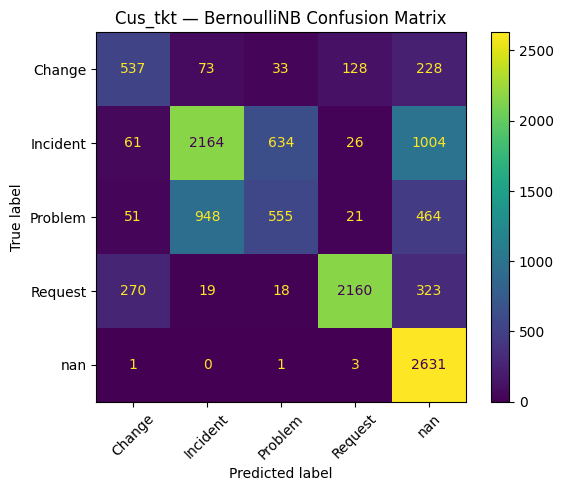

BNB ROC-AUC: 0.8913981252394692


In [21]:
# MODEL 3 — BernoulliNB

print("\n================ BernoulliNB ================")

Cus_tkt_scaler_bnb = Cus_tkt_MinMaxScaler()
Cus_tkt_X_train_bnb = Cus_tkt_scaler_bnb.fit_transform(Cus_tkt_X_train_res)
Cus_tkt_X_test_bnb  = Cus_tkt_scaler_bnb.transform(Cus_tkt_X_test)

# Binarize features
Cus_tkt_binarizer = Cus_tkt_Binarizer(threshold=0.3)
Cus_tkt_X_train_bnb_bin = Cus_tkt_binarizer.transform(Cus_tkt_X_train_bnb)
Cus_tkt_X_test_bnb_bin  = Cus_tkt_binarizer.transform(Cus_tkt_X_test_bnb)

Cus_tkt_bnb_model = Cus_tkt_BernoulliNB()

Cus_tkt_bnb_param_grid = {
    "alpha": [0.1, 0.5, 1.0]
}

Cus_tkt_bnb_grid = Cus_tkt_GridSearchCV(
    estimator=Cus_tkt_bnb_model,
    param_grid=Cus_tkt_bnb_param_grid,
    scoring="f1_macro",
    cv=2,
    n_jobs=-1,
    verbose=1
)

print("Training BernoulliNB...")
Cus_tkt_bnb_grid.fit(Cus_tkt_X_train_bnb_bin, Cus_tkt_y_train_res)
Cus_tkt_bnb_best = Cus_tkt_bnb_grid.best_estimator_

Cus_tkt_y_pred_bnb = Cus_tkt_bnb_best.predict(Cus_tkt_X_test_bnb_bin)

print("\nBernoulliNB Classification Report:")
print(Cus_tkt_classification_report(Cus_tkt_y_test, Cus_tkt_y_pred_bnb, target_names=Cus_tkt_classes))

Cus_tkt_ConfusionMatrixDisplay.from_predictions(
    Cus_tkt_y_test, Cus_tkt_y_pred_bnb, display_labels=Cus_tkt_classes, xticks_rotation=45
)
Cus_tkt_plt.title("Cus_tkt — BernoulliNB Confusion Matrix")
Cus_tkt_plt.show()

Cus_tkt_y_proba_bnb = Cus_tkt_bnb_best.predict_proba(Cus_tkt_X_test_bnb_bin)
print("BNB ROC-AUC:", Cus_tkt_roc_auc_score(Cus_tkt_y_test, Cus_tkt_y_proba_bnb, multi_class="ovr"))
